# Explosive Narratives: Terrorism through the Cinematic Lens
## Boat2023 Milestone 2

In this preparatory part of the project, we agreed on our project proposal; the impact on terrorism on cinema. We performed initial analyses including data exploration, data pre-processing and initial data visualizations, all in relation to our research questions: emotional depiction of terrorism-related movies, genre association, topic analysis as well as popularity.

In [1]:
from helpers import *

#useful imports
import xml.etree.ElementTree as ET
import pandas as pd
from typing import Dict
import json
import re
import ast
from countryinfo import CountryInfo

#important libraries for data visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np
from scipy import stats
import statsmodels.formula.api as smf


#important libraries for the Sentiment analysis
from scipy.signal import savgol_filter
import nltk
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

FILE_ID = '1UKCPLE0QpJGDncD6zvXfSIil0pRlCj-c'
LOCAL_FILE_NAME='local_title_data.tsv'

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


The large file cannot be pushed to the github, so we uploaded the dataset on googleDrive. We download the dataset in local to be able to work with it

In [2]:
download_data(FILE_ID,LOCAL_FILE_NAME)

file already exists


## 1. Data Pre-processing

### 1.1 Import Data

In [3]:
plot_path= 'data/plot_summaries.txt'
movie_metadata_path = 'data/movie.metadata.tsv'
external_title_path= LOCAL_FILE_NAME
external_rating_path= 'data/data.tsv'

In [4]:
m_plot = pd.read_csv(plot_path, delimiter='\t', header= None)
m_column_names = ['W_movie ID', 'F_movie ID', 'Movie name', 'Release date', 'Box office revenue', 'Runtime', 'Languages', 'Countries', 'Genres']
m_data = pd.read_csv('data/movie.metadata.tsv', delimiter= '\t',on_bad_lines='skip', names=m_column_names, header=0)
m_data_copy = m_data.copy() #We make a copy of the data set in case
rating_data=pd.read_csv(external_rating_path,delimiter='\t', on_bad_lines='skip', header=0)
external_title= pd.read_csv(external_title_path,delimiter='\t', on_bad_lines='skip', header=0)

/var/folders/f6/p2jq7zvd7jq9y5mvqb6p1wlh0000gn/T/ipykernel_29396/2618959230.py:6: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  external_title= pd.read_csv(external_title_path,delimiter='\t', on_bad_lines='skip', header=0)


In [5]:
m_data.head(5)

,W_movie ID,F_movie ID,Movie name,Release date,Box office revenue,Runtime,Languages,Countries,Genres
0,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
1,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
2,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
3,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"
4,13696889,/m/03cfc81,The Gangsters,1913-05-29,NaN,35.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen..."


When displaying the dataframe, we notice that the columns Countries, Languages and Genres include some kind of ID, in addition to the readable value we are interest in (for example {"/m/0chghy": "Australia"}). To get a more visually pleasing dataframe, we use the JSON library as follows.

In [6]:
# Function to extract the readable values from the strings
def extract_values(text):
    try:
        # Load the text as JSON and extract values
        data_dict = json.loads(text)
        return ', '.join(data_dict.values())
    except json.JSONDecodeError:
        # If it's not valid JSON, try to find all readable parts with regex
        return ', '.join(re.findall(r'":\s*"([^"]+)"', text))

# Apply the function to clean the columns of our dataframe
m_data['Countries'] = m_data['Countries'].apply(extract_values)
m_data['Languages'] = m_data['Languages'].apply(extract_values)
m_data['Genres'] = m_data['Genres'].apply(extract_values)
m_data.head(2)

,W_movie ID,F_movie ID,Movie name,Release date,Box office revenue,Runtime,Languages,Countries,Genres
0,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,English Language,United States of America,"Mystery, Biographical film, Drama, Crime Drama"
1,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,Norwegian Language,Norway,"Crime Fiction, Drama"


### 1.2 Filter Terrorism-Related Movies and Other Movies

Since our research focuses on the impact of terrorism on movies, we need to filter the dataset to solely target movies related to terrorism. We did some research and crafted a list of keywords of the terrorism lexicon, mainly based on information from Wikipedia. We used this list to create a subset of our original dataset, that we will use for all our analyses.

In [7]:
KEYWORDS = [ "Terrorism", "Terrorist", "Terrorists", "Jihad", "Extremism", "Extremist", "Attacks", "Attack", "Bombs", "Bombing", "Bombers", 
            "Hijack", "Hijacking", "Kidnap", "Kidnapping", "Counterterrorism", "Counterterrorist", "Radicalization", "Radicalized", 
            "Security Threat", "Political Violence", "Suicide Bomber", "War on Terror", "Homeland Security", "National Security", "Intelligence Agencies", 
            "Counterinsurgency", "Terrorist Cells", "Radical Ideology", "Terrorist Plot", "Terrorist Organization", "Hostage Crisis", "Terrorism Investigation", 
            "Counterterrorist Operation", "Radical", "Guerrilla Warfare", "Insurgency", "Terror Threat", "Covert Operations", "Political Unrest", "Martyrdom", 
            "Cyberterrorism", "Terrorism Financing", "Violent Extremism", "Terrorist Recruitment", "Suicide Attacks", "Terrorist Sleeper Cells", 
            "Counterterror Measures", "Clandestine Activities", "Security Intelligence" ]

In [8]:
movie_ids=[]
# Create a new column in the DataFrame to store the count of keywords in each movie plot
for index, row in m_plot.iterrows():
    movie_id = row[0]
    plot = row[1]
    # Check if the plot contains any of the keywords
    for keyword in KEYWORDS:
        if keyword.lower() in plot:
            movie_ids.append(movie_id)
# Display the list of movie IDs that match the keywords
movie_ids= set(movie_ids)

In [9]:
# Terrorism-related movies
terrorism_movies = m_data[m_data['W_movie ID'].isin(movie_ids)][['W_movie ID','Movie name', 'Release date','Countries', 'Languages', 'Genres','Box office revenue']]
terrorism_movies = terrorism_movies.sort_values(by=['Release date'])
terrorism_movies.head(2) 

,W_movie ID,Movie name,Release date,Countries,Languages,Genres,Box office revenue
42214,32986669,Robbery Under Arms,1907-11-02,Australia,Silent film,"Silent film, Drama",NaN
64189,7870349,Dr. Jekyll and Mr. Hyde,1908-03-07,United States of America,Silent film,"Short Film, Silent film, Horror, Indie, Black-...",NaN


In [10]:
#Rename the column of dataframe that contains the plot summaries
df_plot = m_plot.rename(columns={0: 'W_movie ID', 1: 'summary'})
#Merge the dataframe related to the movies metadata and movies plot
df_terrorism_summaries = pd.merge(terrorism_movies, df_plot, on='W_movie ID', how='inner')
#Drop the rows where the box office revenue is nan
df_terrorism_summaries.drop('Box office revenue', axis =1, inplace=True)
df_terrorism_summaries.head(3)

,W_movie ID,Movie name,Release date,Countries,Languages,Genres,summary
0,32986669,Robbery Under Arms,1907-11-02,Australia,Silent film,"Silent film, Drama",Key scenes of the film included the branding o...
1,7870349,Dr. Jekyll and Mr. Hyde,1908-03-07,United States of America,Silent film,"Short Film, Silent film, Horror, Indie, Black-...",Dr. Jekyll and Mr. Hyde began with the raising...
2,29391146,The Black Viper,1908-07-25,United States of America,Silent film,Silent film,A thug accosts a girl as she leaves her workpl...


We change the Release data column. We don't need the exact date, we are only interested in the year. 

In [11]:
terrorism_movies = terrorism_movies.sort_values(by=['Release date'])
terrorism_movies['Release date']=  terrorism_movies['Release date'].str[:4]

## 2. First visualizations

### 2.1 Terrorism-related movies per year.

In [12]:
# We drop the movies that have a NaN value in the release date column
terrorism_movies.dropna(subset=['Release date'], inplace=True)

# Create the histogram using Plotly Express
fig = px.histogram(terrorism_movies, x='Release date',
                   nbins=100,
                   title='Number of Terrorism-Related Movies Per Year',
                   color_discrete_sequence=['#21918c'])

# Update layout for a better appearance
fig.update_layout(
    xaxis_title='Release Year',
    yaxis_title='Number of Movies',
    xaxis_tickangle=-45,
    bargap=0.05 # Smaller gap between bars
)

# Show the figure
fig.show()


### 2.2 Terrorism-related movies per country

We keep the n most represented countries in the visualisation. 

In [13]:
def plot_interactive_pie(df, column, title, n, color_palette):
    counts = df[column].value_counts()
    # Keep the top n and sum the rest under "Others"
    top_counts = counts[:n]
    top_counts['Others'] = counts[n:].sum()
    fig = px.pie(values=top_counts, names=top_counts.index, title=title, 
                 color_discrete_sequence=color_palette)
    fig.update_traces(textinfo='percent+label')
    fig.show()

In [14]:
#Removing the NaN values from the Countries column
df_terrorism_summaries = df_terrorism_summaries[df_terrorism_summaries['Countries'] != '']

exploded = df_terrorism_summaries.explode('Countries')

color_palette_pie = ['#fde725', '#5ec962', '#21918c', '#3b528b', '#440154']
plot_interactive_pie(exploded, 'Countries', 'Percentage of Movies on terrorism per Country', 4, color_palette_pie)

In [15]:
import pycountry
import plotly.graph_objects as go

#to be able to use Plotly's Choropleth map function
def get_iso_code(country_name):
    try:
        return pycountry.countries.lookup(country_name).alpha_3
    except LookupError:
        return None  # If the country name is not found, return None

# Apply the function to get ISO codes
df_terrorism_summaries['iso_alpha'] = df_terrorism_summaries['Countries'].apply(get_iso_code)

# create a Choropleth map:

# Group by 'iso_alpha' to get the count of movies per country code
movie_counts = df_terrorism_summaries.groupby('iso_alpha').size().reset_index(name='Movie Count')

# Create the Choropleth map
fig = go.Figure(data=go.Choropleth(
    locations=movie_counts['iso_alpha'],  # ISO codes for countries
    z=movie_counts['Movie Count'],  # Data to be color-coded
    text=movie_counts['iso_alpha'],  # Country codes
    colorscale='Viridis',
    autocolorscale=False,
    reversescale=False,
    marker_line_color='darkgray',
    marker_line_width=0.5,
    colorbar_title='Number of Movies',
))

fig.update_layout(
    title_text='Number of Terrorism-related Movies per Country',
    geo=dict(
        showframe=False,
        showcoastlines=False,
        projection_type='equirectangular'
    ),
)
fig.show()

## 4. Are there specific genres associated to terrorism movies?

Each movie is associated with various genres. The genre of a movie is a way to categorize it. It reflects the movie’s narrative elements, thematic content, stylistic approach, and the emotional response it aims to evoke in the audience. It allows audiences and film-makers to understand the type of content they can expect from a movie. 

Below, we describe each method that we will be using to analyze the association between genres and terrorism movies.
For each method, we describe what the method does, why it is interesting in the context of genres and terrorism movies and how it works.

We also do the necessary data pre-processing for each method, as well as the first visualizations.

The analysis is in three parts: Frequency analysis, heatmap of counts of movies of certain genres of different countries, and a chi-squared independence test.

### 4.1 Frequency Analysis
__What It Does__: Frequency analysis counts how often each genre appears in movies about terrorism vs in non-terrorism movies.

__Why It’s Interesting__: This method would provide a clear, quantitative measure of the association between genres and terrorism-themed movies. It could reveal if terrorism movies are associated with certain genres, like action or drama.

__How It Works__: We first filter our dataset for movies that are classified as related to terrorism. We do this by keyword search within movie descriptions. We define a list of keywords that are associated with terrorism, then only keep the movies whose plot contains at least one of these keywords. Then, we count the frequency of each genre within this subset and compare it to the overall frequency of genres in the entire dataset.

__Data Pre-Processing and Visualization__: We need to write a code that allows to count the genres. We also do a visualization of the top 10 most common genres in non-terrorism movies vs in terrorism-related movies.

We want to compare the frequency of genres between terrorism-related movies and non-terrorism-related movies.

In [16]:
#Non-terrorism movies in their original format
non_terrorism_movies = m_data_copy[~m_data_copy['W_movie ID'].isin(movie_ids)]
#Terrorism movies in their original format
t_movies = m_data_copy[m_data_copy['W_movie ID'].isin(movie_ids)][['W_movie ID','Movie name', 'Release date','Countries', 'Languages', 'Genres','Box office revenue']]
t_movies = t_movies.sort_values(by=['Release date'])
print(f"Number of terrorism-related movies: {len(t_movies)}")
print(f"Number of non terrorism-related movies: {len(non_terrorism_movies)}")

Number of terrorism-related movies: 8626
Number of non terrorism-related movies: 73114


In the data set without terrorism-related movies `non_terrorism_movies`, we have 73114 movies.
In the filtered data set `t_movies`, we have 8626 movies, which correspond to terrorism-related movies.

In [17]:
display(non_terrorism_movies.head(2))

,W_movie ID,F_movie ID,Movie name,Release date,Box office revenue,Runtime,Languages,Countries,Genres
0,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
1,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."


In [18]:
display(t_movies.head(2))

,W_movie ID,Movie name,Release date,Countries,Languages,Genres,Box office revenue
42214,32986669,Robbery Under Arms,1907-11-02,"{""/m/0chghy"": ""Australia""}","{""/m/06ppq"": ""Silent film""}","{""/m/06ppq"": ""Silent film"", ""/m/07s9rl0"": ""Dra...",NaN
64189,7870349,Dr. Jekyll and Mr. Hyde,1908-03-07,"{""/m/09c7w0"": ""United States of America""}","{""/m/06ppq"": ""Silent film""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen...",NaN


In [19]:
#Define a function to parse the genre column
def parse(str):
    try:
        # Convert the string representation of a dictionary into an actual dictionary
        dict_ = ast.literal_eval(str)
        # Return the values (genres) of the dictionary
        return list(dict_.values())
    except ValueError:
        # In case of any parsing error, return an empty list
        return []

Now, we start the genre analysis. We want to take a look at the top 10 most common genres in both terrorism-related movies `t_movies` and non-terrorism-related movies.

/var/folders/f6/p2jq7zvd7jq9y5mvqb6p1wlh0000gn/T/ipykernel_29396/4056011177.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



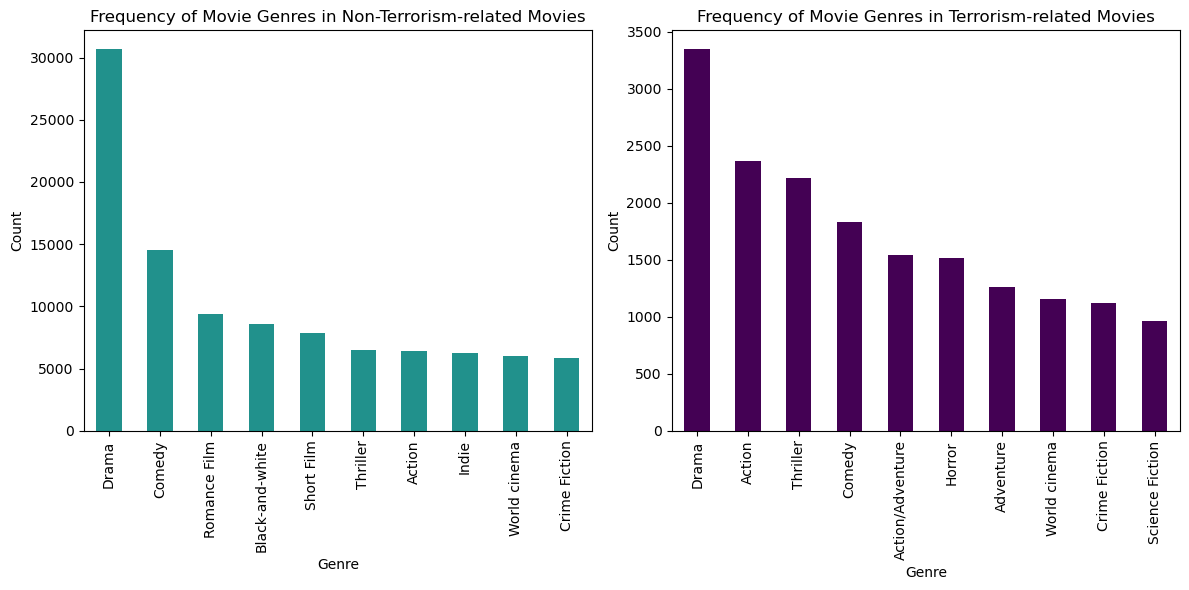

In [20]:
## Non-terrorism movies

#Apply the function to each row in the genre column and flatten the list of lists
non_terrorism_movies['Genres'] = non_terrorism_movies['Genres'].apply(parse)
all_genres = [genre for sublist in non_terrorism_movies['Genres'] for genre in sublist]

#Create a frequency count of each genre
genre_counts = pd.Series(all_genres).value_counts()

#Only keep the top 10 most common genres
top_10_non_terrorism_movies = genre_counts.nlargest(10)

## Terrorism-related movies

#Apply the function to each row in the genre column and flatten the list of lists
t_movies['Genres'] = t_movies['Genres'].apply(parse)
all_genres = [genre for sublist in t_movies['Genres'] for genre in sublist]

#Create a frequency count of each genre
genre_counts = pd.Series(all_genres).value_counts()

#Only keep the genres that are present in more than 1000 movies
top_10_terrorism_movies = genre_counts.nlargest(10)
top_10_terrorism_genres = list(top_10_terrorism_movies.index)

#Plot the barplots of movie genres for terrorism vs non-terrorism-related movies
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

top_10_non_terrorism_movies.plot(kind='bar', ax=axes[0], color='#21918c')
axes[0].set_title('Frequency of Movie Genres in Non-Terrorism-related Movies')
axes[0].set_xlabel('Genre')
axes[0].set_ylabel('Count')

top_10_terrorism_movies.plot(kind='bar', ax=axes[1], color='#440154')
axes[1].set_title('Frequency of Movie Genres in Terrorism-related Movies')
axes[1].set_ylabel('Count')
axes[1].set_xlabel('Genre')

plt.tight_layout()
plt.show()

In the plots above, we have plotted the counts of non-terrorism-related movies and terrorism-related movies against the different genres. We only plot the 10 most common genres.
**Discuss**: 
1) What are the most prevalent genres of non-terrorism movies? What are the most prevalent genres of terrorism movies? Do they differ?
- The top 10 most common genres of terrorism movies are: Drama, Action, Thriller, Comedy, Action/Adventure, Horror, Adventure, World cinema, Crime fiction and Science fiction.
- The top 10 most common genres of non-terrorism movies are: Drama, Comedy, Romance Film, Black-and-white, Short film, Thriller, Action, Indie, World cinema and Crime ficiton.
- We notice that for both sets of movies, the most prevalent genre is Drama. This could suggest that dramatic elements are central to storytelling in films regardless of the terrorism theme. 

Now, let's focus on the top 10 most common genres in terrorism related movies. To have a better comparison, we will look at the proportion of terrorism vs non-terrorism movies in each genre.

In [21]:
# Explode the 'Genres' column to have one genre per row
exploded_genres = non_terrorism_movies.explode('Genres')

# Filter out only the genres that are in the top 10 terrorism genres
filtered_genres = exploded_genres[exploded_genres['Genres'].isin(top_10_terrorism_genres)]

# Create a frequency count of each genre
genre_counts = filtered_genres['Genres'].value_counts()

# Get the counts for the top 10 terrorism genres
top_non_terrorism_movies = genre_counts.reindex(top_10_terrorism_genres).fillna(0)

In [22]:
proportion_non_terrorism_movies = top_non_terrorism_movies*100/len(non_terrorism_movies)
proportion_terrorism_movies = top_10_terrorism_movies*100/len(t_movies)

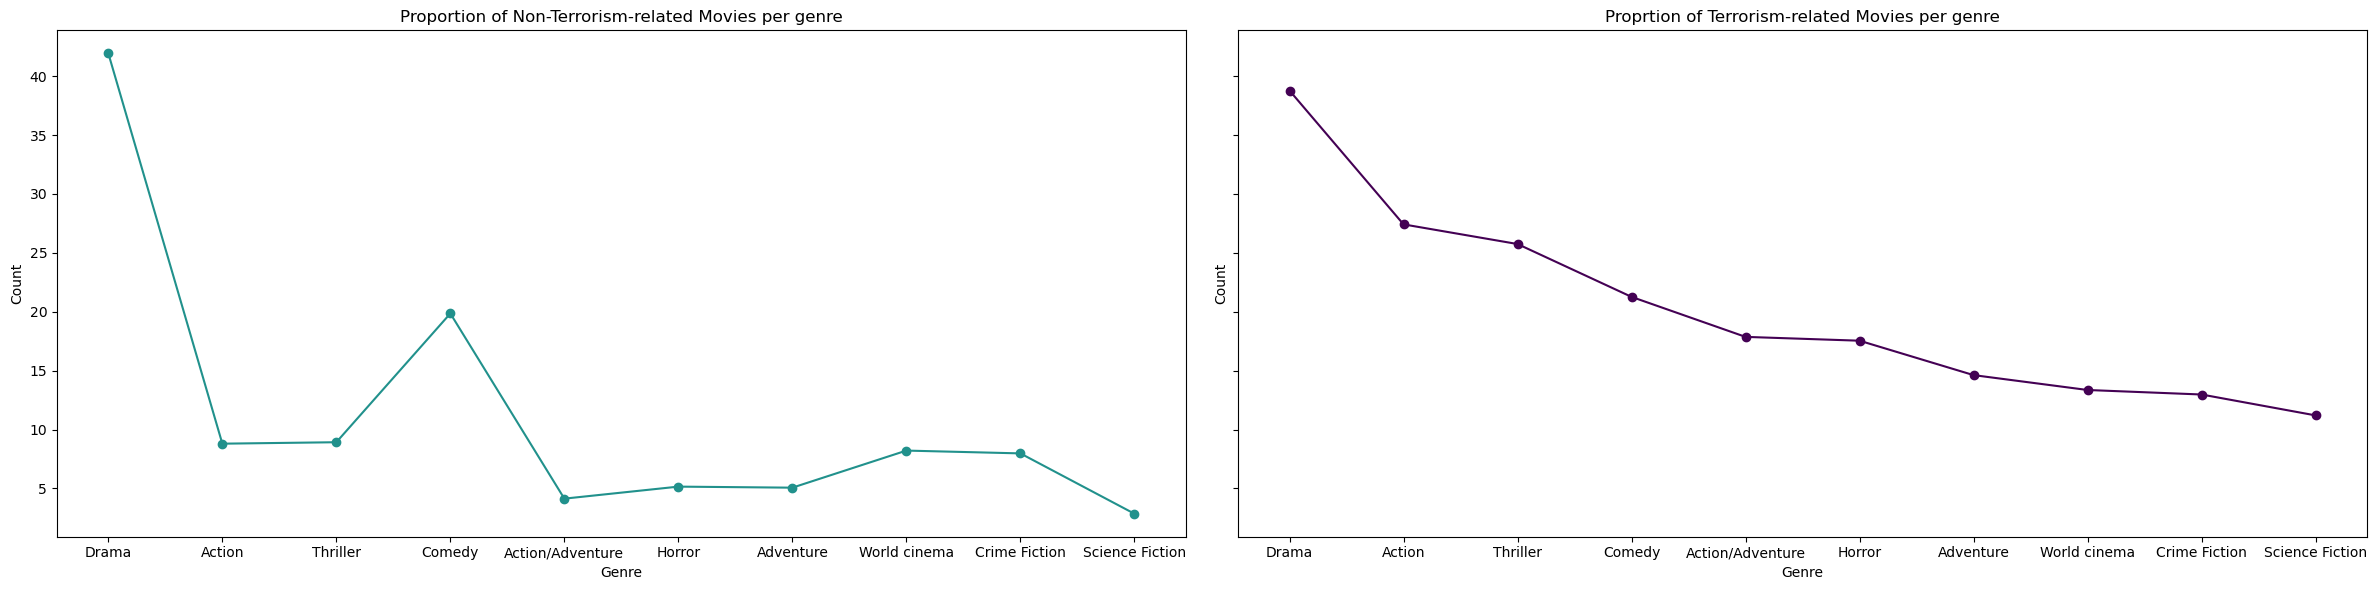

In [23]:
#Plot the barplots of movie genres for terrorism vs non-terrorism-related movies
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(24, 6), sharex=True, sharey=True)

axes[0].plot(proportion_non_terrorism_movies, marker='o', color='#21918c')
axes[0].set_title('Proportion of Non-Terrorism-related Movies per genre')
axes[0].set_xlabel('Genre')
axes[0].set_ylabel('Count')

axes[1].plot(proportion_terrorism_movies, marker='o', color='#440154')
axes[1].set_title('Proprtion of Terrorism-related Movies per genre')
axes[1].set_ylabel('Count')
axes[1].set_xlabel('Genre')

plt.tight_layout()
plt.show()

In the plot above, we plot the proprtion of terrorism and non-terrorism related movies in each genre. The genres we are interested in are the top 10 most common genres of terrorism-related movies found before.

**Discuss** 
1) What genres are more prevalent in terrorism related movies than in non-terrorism related movies?
- Action and Thriller: These genres seem to be more prevalent in terrorism-related movies when compared to non-terrorism-related movies. 
- Adventure and Horror: While not as dominant as Drama, Action, or Thriller, these genres also appear more frequently in terrorism-related movies than in non-terrorism-related ones.
- Drama: This genre has a very high proportion in both terrorism and non-terrorism related movies.

2) How do these genre preferences for terrorism movies reflect cultural attitudes towards terrorism? Do they suggest that certain genres are better suited to explore terrorism-related themes?
- Action and Thriller: These genres are traditionally associated with high energy, suspense, and conflict, which are common elements in terrorism narratives. The prevalence of Action and Thriller genres in terrorism-related movies could reflect the intensity and high stakes often associated with terrorism. 
- Adventure and Horror: These genres could be more prevalent due to the way they can incorporate elements of the unknown and fear, which can reflect unpredictability and fear associated with acts of terrorism.
- Drama: While Drama is prevalent in both types of movies, its slightly reduced prevalence in terrorism-related movies compared to non-terrorism-related ones might indicate that while dramatic storytelling is universal, terrorism movies might need the inclusion of action or thriller elements to better portray the specific themes associated to terrorism.

3) Do these genre trends in terrorism-related movies reflect a global influence, or are they more indicative of Western cinematic trends?
We discuss this in **section 4.2**.

4) Evolution Over Time: How have the representations of terrorism in various genres evolved over time? We discuss this in **section 4.4**.

### 4.2 Heatmap of genres of terrorism movies between different regions/countries

__What It Does__: The heatmap will show the counts of movies of each genre for each region/country.

__Why It’s Interesting__: This method would provide a qualitative measure of the association between genres of terrorism-themed and regions/countries. It could reveal if terrorism movies in the USA or the United Kingdom are associated with certain genres, like action or drama, etc.

__How It Works__: We create a matrix where each cell contains the count of movies for a particular genre in a particular region/country.

__Data Pre-Processing and Visualization__: To prepare our data, we need to ensure that the dataset is structured so that each movie has a genre list and an associated region/country.

In [24]:
t_movies['Countries'] = t_movies['Countries'].apply(parse)
t_movies['Languages'] = t_movies['Languages'].apply(parse)

In [25]:
#If a movie is associated with multiple countries, create a separate row for each country.
exploded_countries = t_movies.explode('Countries')

In [26]:
exploded_countries = exploded_countries.dropna()
    
exploded_countries['Countries'] = exploded_countries['Countries'].replace('Yugoslavia', 'Serbia')
exploded_countries['Countries'] = exploded_countries['Countries'].replace('England', 'United Kingdom')
exploded_countries['Countries'] = exploded_countries['Countries'].replace('Socialist Federal Republic of Yugoslavia'  , 'Serbia') 
exploded_countries['Countries'] = exploded_countries['Countries'].replace('West Germany'  , 'Germany') 
exploded_countries['Countries'] = exploded_countries['Countries'].replace('Scotland'  , 'United Kingdom') 
exploded_countries['Countries'] = exploded_countries['Countries'].replace('Korea'  , 'South Korea') 
exploded_countries['Countries'] = exploded_countries['Countries'].replace('Bahamas'  , 'Canada') 

In [27]:
# Get unique countries to minimize API calls or computation
unique_countries = exploded_countries['Countries'].unique()

# Create a dictionary to hold the countries and their corresponding regions
country_to_region = {}

# Iterate over unique countries and fetch their regions
for country in unique_countries:
    try:
        country_info = CountryInfo(country)
        # Store the country and its region in the dictionary
        country_to_region[country] = country_info.info().get('region', 'Unknown')  # 'Unknown' is a default value
    except KeyError:
        # Handle cases where the country is not found in the CountryInfo database
        country_to_region[country] = 'Unknown'

# Map the countries in the DataFrame to their corresponding regions using the dictionary
exploded_countries['Region'] = exploded_countries['Countries'].map(country_to_region)

Text(0, 0.5, 'Movies')

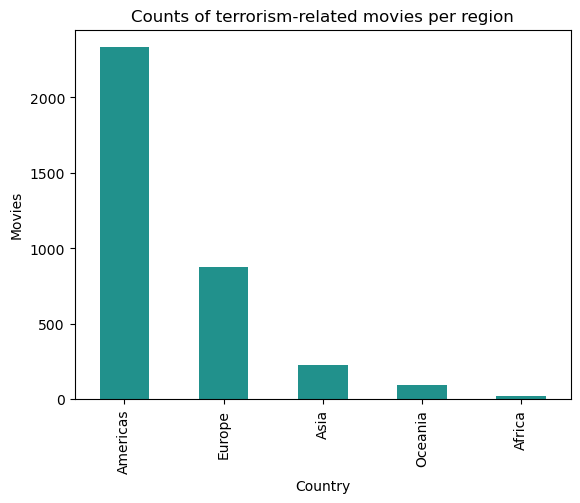

In [28]:
#Count the occurrences of each region
region_counts = exploded_countries['Region'].value_counts()

plt.figure()
region_counts.plot(kind='bar', color='#21918c')
plt.title('Counts of terrorism-related movies per region')
plt.xlabel('Country')
plt.ylabel('Movies')

In [29]:
#Explode the data frame w.r.t. Genres
exploded_countries_genres = exploded_countries.explode('Genres')

#Define the genres of interest (top 10 most common genres found in section 4.1)
genres_of_interest = ['Drama', 'Action', 'Thriller', 'Comedy', 'Action/Adventure', 'Horror',
                          'Adventure', 'World cinema', 'Crime Fiction', 'Science Fiction']

#Only keep elements of the exploded data that have one of the genres of itnerest
temp_regions = exploded_countries_genres[
    exploded_countries_genres['Genres'].isin(genres_of_interest)]

# Create a pivot table with countries as rows, genres as columns, and counts as values
heatmap_set_regions = pd.pivot_table(temp_regions, index='Region', columns='Genres', aggfunc='size', fill_value=0)

# Create a heatmap using Plotly
fig = go.Figure(data=go.Heatmap(
    z=heatmap_set_regions.values,
    x=heatmap_set_regions.columns,
    y=heatmap_set_regions.index,
    colorscale='Viridis'  # Using the Viridis color palette
))

# Update layout for a better appearance
fig.update_layout(
    title='Heatmap of Movie Genres by Region',
    xaxis_title='Genre',
    yaxis_title='Country'
)

# Show the figure
fig.show()

Now, let's do the same analysis but by focusing on the 10 countries that have the most terrorism-related movies.

Text(0, 0.5, 'Movies')

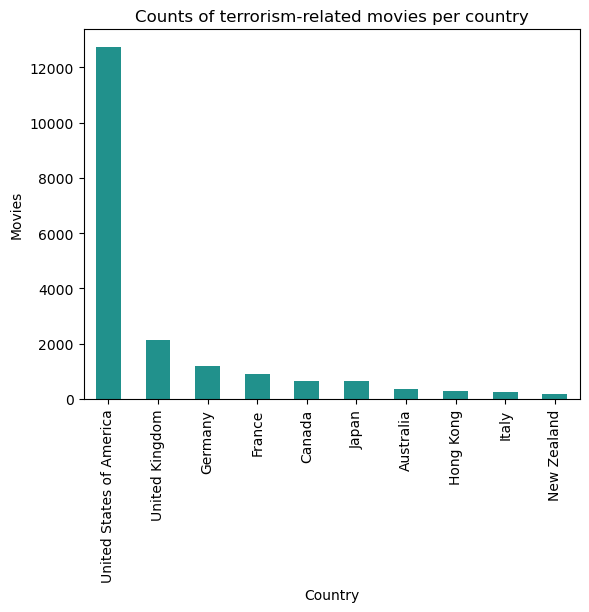

In [30]:
#Count the occurrences of each country
country_counts = exploded_countries_genres['Countries'].value_counts()

#Only keep the 10 countries that have the most movies
country_counts = country_counts.nlargest(10)

plt.figure()
country_counts.plot(kind='bar', color='#21918c')
plt.title('Counts of terrorism-related movies per country')
plt.xlabel('Country')
plt.ylabel('Movies')

Now, we only keep the movies that are from at least one of the 10 countries mentioned before, and that have at least one genre from the 10 genres mentioned before.

In [31]:
#Define the countries of interest
countries_of_interest = [
        "United States of America", "United Kingdom", "India", "Japan",
        "France", "Germany", "Canada", "Italy", "Hong Kong", "Australia"]

#Only keep elements of the exploded data that have one of the countries of interest and one of the genres of interest
temp_countries = exploded_countries_genres[
    exploded_countries_genres['Countries'].isin(countries_of_interest) & 
    exploded_countries_genres['Genres'].isin(genres_of_interest)]

# Create a pivot table with countries as rows, genres as columns, and counts as values
heatmap_set_countries = pd.pivot_table(temp_countries, index='Countries', columns='Genres', aggfunc='size', fill_value=0)

# Create a heatmap using Plotly
fig = go.Figure(data=go.Heatmap(
    z=heatmap_set_countries.values,
    x=heatmap_set_countries.columns,
    y=heatmap_set_countries.index,
    colorscale='Viridis'  # Using the Viridis color palette
))

# Update layout for a better appearance
fig.update_layout(
    title='Heatmap of Movie Genres by Country',
    xaxis_title='Genre',
    yaxis_title='Country'
)

# Show the figure
fig.show()

As we can see, since there are a lot more movies from the USA, we can't really see the variation between genres for the rest of the countries. 
Therefore, we decided to check out the genre frequency of the USA movies alone, and repeat the visualization for the rest of the countries.

First, let's remove the USA from list of countries of interest.

In [32]:
#Define the countries of interest
countries_of_interest = ["United Kingdom", "India", "Japan",
        "France", "Germany", "Canada", "Italy", "Hong Kong", "Australia"]

#Only keep elements of the exploded data that have one of the countries of interest and one of the genres of interest
temp_countries = exploded_countries_genres[
    exploded_countries_genres['Countries'].isin(countries_of_interest) & 
    exploded_countries_genres['Genres'].isin(genres_of_interest)]

# Create a pivot table with countries as rows, genres as columns, and counts as values
heatmap_set_countries = pd.pivot_table(temp_countries, index='Countries', columns='Genres', aggfunc='size', fill_value=0)

Finally, we compute the counts of movies per genre in the USA.

In [33]:
temp_USA = exploded_countries_genres[exploded_countries_genres['Countries'] == 'United States of America']
temp_USA = temp_USA[temp_USA['Genres'].isin(genres_of_interest)]

#Count the occurrences of each country
genre_counts_USA = temp_USA['Genres'].value_counts()

Now, let's visualize the heatmap of Movie Genres by Region, by Country, and a bar chart for the counts of movies per genre in the USA.


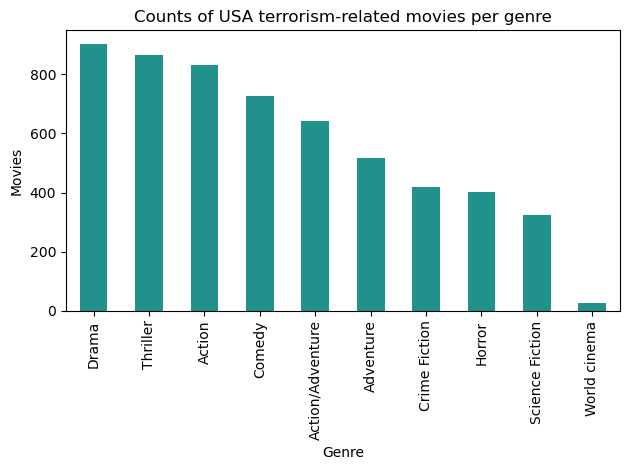

In [34]:
#Plot the barplots of movie genres for terrorism vs non-terrorism-related movies
plt.figure()

genre_counts_USA.plot(kind='bar', color='#21918c')
plt.title('Counts of USA terrorism-related movies per genre')
plt.xlabel('Genre')
plt.ylabel('Movies')

plt.tight_layout()
plt.show()

**Discuss**
The prevalence of genres like Drama and Thriller in many regions might indicate a universal appeal of intense narratives that deal with complex human emotions and ethical dilemmas, which are often at the core of terrorism-related stories. In contrast, regions where certain genres are more popular may reflect regional storytelling traditions or preferences, such as a penchant for Action/Adventure in the Americas, which could be tied to the Hollywood influence and its history of high-stakes blockbusters.

Economic factors, including the availability of funding and resources, market size, and audience demographics, can significantly influence which genres are produced within a region. For instance, regions where Action/Adventure and Thriller genres are highly prevalent may have more established film industries capable of supporting the high production costs associated with these genres. They may also have larger audiences that provide the box office revenues needed to justify such investments.

The representation of certain genres, such as Action/Adventure and Drama, across multiple regions suggests that these genres have broad international appeal, likely influenced by the widespread distribution of Hollywood films. However, the presence of genres like World Cinema, which is more prevalent in Europe, indicates that unique cultural differences and cinematic expressions still persist despite the forces of globalization.

As we can notice, except for Hong Kong and Japan, the most prevalent genre is Drama. In the part about sentimental analysis, it could be interesting to only focus on the Drama movies and see whether the way each country depicts its Drama terrorism-related movies is different, sentimental-wise.

### 4.3 Chi-Square Test of Independence
__What It Does__: Tests whether there is a significant association between movie genres and their portrayal of terrorism.

__Why It’s Interesting__: This statistical test can validate whether any observed association between genres and terrorism portrayal is statistically significant, rather than due to random chance.

__How It Works__: The Chi-Square test will tell you whether the distribution of genres in terrorism-related movies is different from what would be expected if there was no association between genre and terrorism content.

__Data Pre-Processing Needed__: You will need a table where one column is genres and the other is a binary variable indicating whether the movie is terrorism-related.

First, we create a new column for the feature Terrorism-related. This feature is binary. Its value is 1 if the movie is terrorism-related, and it is 0 if it is not.

In [35]:
m_data_chi = m_data_copy.copy()
m_data_chi['Terrorism-related'] = m_data_copy['W_movie ID'].apply(lambda x: 1 if x in movie_ids else 0)

m_data_chi['Release year'] = m_data_chi['Release date'].str[:4]
m_data_chi.drop(columns=['F_movie ID','Box office revenue', 'Runtime', 'Release date'], axis=1, inplace=True)

Now, we process the Genres columns in the m_data_chi DataFrame that contain JSON-like strings. We convert the strings in these columns into Python lists containing the values from the JSON object.

In [36]:
json_cols = ["Genres"]
for col in json_cols:
    m_data_chi[col] = m_data_chi[col].apply(lambda x: list(json.loads(x).values()))

Finally, we create the chi-square test data that is a table where one column is the Genre and the other is the Terrorism-related binary variable.

In [37]:
exploded_data = m_data_chi.explode('Genres')
chi_square_data = exploded_data[['Genres', 'Terrorism-related']]
chi_square_data.head()

,Genres,Terrorism-related
0,Mystery,0
0,Biographical film,0
0,Drama,0
0,Crime Drama,0
1,Crime Fiction,0


In [38]:
unique_genres = chi_square_data['Genres'].unique()
# Use pandas factorize
labels, unique = pd.factorize(unique_genres)

# The 'labels' array contains the integer labels for each genre
# The 'unique' array contains the unique genres in the order they were encountered
genre_to_int = {genre: label for genre, label in zip(unique, labels)}

print(genre_to_int)

{'Mystery': 0, 'Biographical film': 1, 'Drama': 2, 'Crime Drama': 3, 'Crime Fiction': 4, 'Thriller': 5, 'Erotic thriller': 6, 'Psychological thriller': 7, 'Short Film': 8, 'Silent film': 9, 'Indie': 10, 'Black-and-white': 11, 'Comedy': 12, 'Family Film': 13, 'Fantasy': 14, 'Adventure': 15, 'World cinema': 16, 'Musical': 17, 'Horror': 18, 'Supernatural': 19, 'Japanese Movies': 20, 'Action/Adventure': 21, 'Romantic comedy': 22, 'Ensemble Film': 23, 'Comedy-drama': 24, 'Romantic drama': 25, 'Romance Film': 26, 'Costume drama': 27, 'War film': 28, 'Epic': 29, 'Period piece': 30, 'Film adaptation': 31, 'Science Fiction': 32, 'Animation': 33, 'Action': 34, "Children's/Family": 35, "Children's Fantasy": 36, 'Future noir': -1, 'Comedy film': 37, 'Coming of age': 38, 'Suspense': 39, 'Crime Thriller': 40, 'Black comedy': 41, 'Bollywood': 42, 'Marriage Drama': 43, 'Wuxia': 44, 'Martial Arts Film': 45, 'Chinese Movies': 46, 'Western': 47, 'Parody': 48, 'Mockumentary': 49, 'Fan film': 50, 'Cult': 5

In [39]:
# Map the list of genres to their corresponding integers
chi_square_data = chi_square_data.dropna()
chi_square_data['Genres'] = [genre_to_int[genre] for genre in chi_square_data['Genres']]

for i in range(len(chi_square_data)):
    if chi_square_data.iloc[i]['Genres'] == -1: 
        chi_square_data['Genres'] = chi_square_data['Genres'].replace(-1, 362)

In [40]:
chi_square_data['Genres']

0          0
0          1
0          2
0          3
1          4
        ... 
81738      2
81739      5
81739     18
81739     83
81739    112
Name: Genres, Length: 243322, dtype: int64

In [41]:
from scipy.stats import chi2_contingency

# Creating a contingency table
contingency_table = pd.crosstab(chi_square_data['Genres'], chi_square_data['Terrorism-related'])

# Performing the Chi-Square Test
chi2, p, dof, expected = chi2_contingency(contingency_table)

results = {
    "Results": ["Chi-Square Statistic", "P-value"],
    "Value": [chi2, p]
}

# Creating a DataFrame to display the results
results_df = pd.DataFrame(results)

# Display the DataFrame
print(results_df)

# Interpret the p-value (assuming a significance level of 0.05)
alpha = 0.05
if p < alpha:
    print("Reject the null hypothesis - there is a significant association between genre and being terrorism-related.")
else:
    print("Fail to reject the null hypothesis - there is no significant association between genre and being terrorism-related.")

                Results         Value
0  Chi-Square Statistic  17893.153178
1               P-value      0.000000
Reject the null hypothesis - there is a significant association between genre and being terrorism-related.


### 4.4: Time Series Analysis per genre


In [42]:
t_movies = t_movies.sort_values(by=['Release date'])
t_movies['Release date']=  t_movies['Release date'].str[:4]

In [43]:
exploded = t_movies.explode('Genres')

In [44]:
import plotly.graph_objects as go
import pandas as pd

# Assuming exploded is your DataFrame and top_10_terrorism_genres is a list of genres

# Create an empty figure
fig = go.Figure()

# Viridis color palette
viridis = px.colors.sequential.Viridis

# Plot each genre's time series on the same figure
for i, g in enumerate(top_10_terrorism_genres):
    temp = exploded[exploded['Genres'] == g]
    time_series = temp.groupby('Release date').size()
    
    # Add the time series to the figure
    fig.add_trace(go.Scatter(
        x=time_series.index, 
        y=time_series, 
        mode='lines',
        name=g,
        line=dict(color=viridis[i % len(viridis)])  # Use color from Viridis palette
    ))

# Set the title and axis labels
fig.update_layout(
    title='Terrorism-Themed Movies Over Time by Genre',
    xaxis_title='Year',
    yaxis_title='Number of Movies',
    legend_title='Genre'
)

# Display the plot
fig.show()



By comparing these plots to the plot done in section 2.1, the number of terrorism-related movies for each genre follow the same general trend as for all terrorism-related movies together. Indeed, we see a net increase of movies over time for all genres. We notice that some genres are more prevalent than others (Drama, Thriller, Action/Adventure and Horror), but we don't see one specific genre that has a different time series compared to the others.
To conclude, the representation of terrorism in various genres have the same evolution over time. We don't notice any specific genre that stands out in this matter.